## Demo Notebook: Behavior clustering

In [1]:
import sys
sys.path.append('/Users/annateruel/socialhierarchy/code/')

from behavioral_clustering import sample_frames, load_features,run_umap, train_embedding_model, predict_embeddings, plot_umap_embedding, map_density

/Users/annateruel/miniconda3/envs/umap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sp_frames = sample_frames(directory='/Users/annateruel/Desktop/features',
                          file_format='csv',
                          frames_total = 100000)

In [3]:
embedding = run_umap(sp_frames)

Running UMAP embedding...


/Users/annateruel/miniconda3/envs/umap/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP completed in 126.53 seconds.
UMAP embedding shape: (99840, 2)


In [ ]:
train_embedding_model(embedding, sp_frames, save_model=True,
                      save_path='/Users/annateruel/Desktop/embedding_model.h5')

In [ ]:
plot_umap_embedding(embedding, save=True, save_dir= '/Users/annateruel/Desktop', format='png')

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter, label, center_of_mass
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import numpy as np

def map_density(embedding, 
                bins=200, 
                sigma=3.5, 
                percentile=30,
                cmap='plasma', 
                plot=True, 
                save=False,
                save_dir=None, 
                format='svg',
                kde_levels=30):
    """
    Compute a density map from the UMAP embedding using KDE and watershed segmentation.

    Args:
        embedding (np.ndarray): 2D UMAP embedding.
        bins (int): Number of bins for 2D histogram.
        sigma (float): Smoothing parameter.
        percentile (int): Density threshold.
        cmap (str): Colormap.
        plot (bool): Whether to plot.
        save (bool): Whether to save the plot.
        save_dir (str): Directory to save if save=True.
        format (str): File format for saving.
        kde_levels (int): Number of contour levels for seaborn.kdeplot.

    Returns:
        labeled_map, density_map, xe, ye
    """

    print("Computing density map...")

    # Density map via 2D histogram
    density_map, xe, ye = np.histogram2d(
        embedding[:, 0], embedding[:, 1], bins=bins, density=True
    )
    density_map = gaussian_filter(density_map, sigma=sigma)
    density_cutoff = np.percentile(density_map, percentile)
    density_mask = density_map > density_cutoff

    # Peak detection
    local_max = peak_local_max(
        density_map, min_distance=1, footprint=np.ones((3, 3)), labels=density_mask
    )
    local_max_mask = np.zeros_like(density_map, dtype=bool)
    local_max_mask[tuple(local_max.T)] = True

    # Watershed
    markers, _ = label(local_max_mask)
    labeled_map = watershed(-density_map, markers, mask=density_mask, connectivity=2)
    labeled_map = labeled_map.astype("float64")

    if plot:
        fig, ax = plt.subplots(figsize=(14, 12))

        # KDE plot
        sns.kdeplot(
            x=embedding[:, 0],
            y=embedding[:, 1],
            fill=True,
            cmap=cmap,
            bw_adjust=0.8,
            thresh=0.01,
            levels=kde_levels,
            ax=ax
        )

        # Remove seaborn's auto-added colorbar (if present)
        if len(fig.axes) > 1 and fig.axes[-1] != ax:
            fig.delaxes(fig.axes[-1])

        # Overlay contours
        extent = [xe[0], xe[-1], ye[0], ye[-1]]
        ax.contour(
            labeled_map.T,
            levels=np.arange(1, np.max(labeled_map) + 1),
            colors="black",
            linewidths=2,
            origin="lower",
            extent=extent,
            alpha=0.7
        )

        # Add cluster labels
        for i in np.unique(labeled_map):
            if i == 0:
                continue
            mask = labeled_map == i
            if np.sum(mask) < 20:
                continue
            com = center_of_mass(mask)
            cx = xe[0] + (xe[-1] - xe[0]) * com[0] / labeled_map.shape[0]
            cy = ye[0] + (ye[-1] - ye[0]) * com[1] / labeled_map.shape[1]
            ax.text(cx, cy, str(int(i)), color="black", fontsize=10, ha="center", va="center")

        # Clean colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
        cbar.set_label("PDF", fontsize=12)
        cbar.ax.tick_params(labelsize=10)

        ax.axis("off")

        if save:
            if save_dir:
                file_path = f"{save_dir}/umap_heatmap.{format}"
                plt.savefig(file_path, dpi=300, format=format, bbox_inches='tight', pad_inches=0.5)
                print(f"UMAP heatmap plot saved to {file_path}")
            else:
                print("Warning: save=True but no save_dir provided. Plot not saved.")

        plt.show()

    return labeled_map, density_map, xe, ye

Computing density map...
UMAP heatmap plot saved to /Users/annateruel/Desktop/umap_heatmap.svg


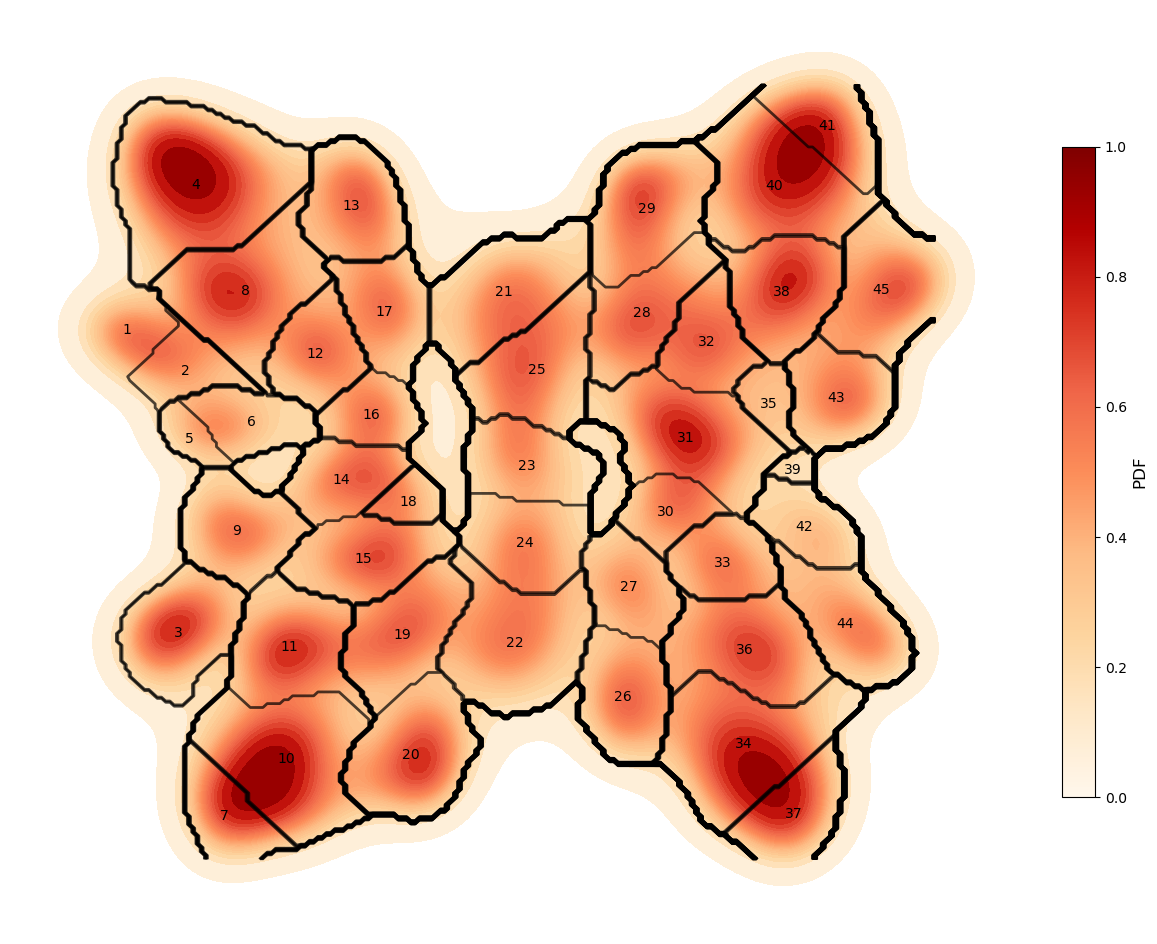

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.03403728e-06, 1.26527083e-06, 9.02197471e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.07328537e-06, 2.54504443e-06, 1.82059584e-06],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.42684256e-06, 5.91769984e-06, 4.24816144e-06],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.06003120e-10, 2.36167252e-10, 1.08512460e-10],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.43144591e-12, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([-1.72325

In [31]:
map_density(embedding, cmap='OrRd', save=True, save_dir='/Users/annateruel/Desktop', format='svg')